# Kernel Density Estimation

IN the previous section we convered GAussian mixture models (GMM), which are a kind of hybrid between a clustering estimator and a density estimator. Recall that a density estimator is an algorithm which takes a $D$-dimensional dataset and produces an estimate of the $D$-dimensional probability distribution which that data is drawn from. The GMM algorithm accomplishes this by representing the density as a weighted sum of GAussian distributions. *Kernel density estimation* (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian compoent *per point*, resulting in an essentially non-parametric estimator of density. In this section, we will explore the motivation and uses of KDE.

We begin with the standard imports:

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset. For one dimensional data, you are probably already familiar with one simple density estimator: the histogram. A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualized the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N): ] += 5
    return x 

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the `plt.hist()` function. By specigying the `normed` parameter of the histogram, we end up with a normalized hisogram where the height of the bins does not reflec counts, but instead refecls probability density:

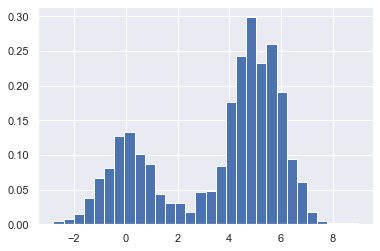

In [7]:
hist = plt.hist(x, bins=30, density=True)

Notice that for equal binning, this normalizatio nsimply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts. This normalization is hocsen so that the total area under the histogram is equaot to 1, as we can confirm by looking at the output of the histogram function:

In [5]:
density, bins, patches = hist 
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with suing a hisogram as a density estimator is that the coice of bin size and location can lead to representations that have qualitatively different features. For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation o fthe data! Consider this example:

In [26]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

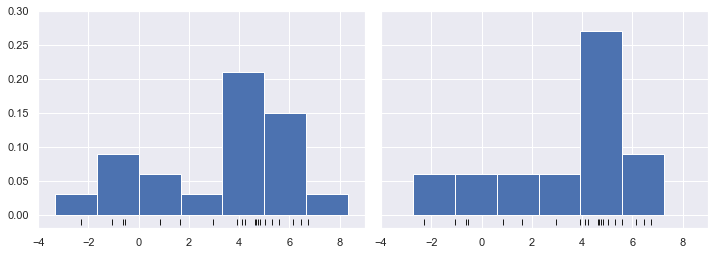

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})

fig.subplots_adjust(wspace=0.05)

for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', 
               markeredgewidth=1)

One the left, the hisogram makes clear that htis is abimodal distribution. On the right, we see a unimodal distribution with a long tail. Wihout seeing the preceding code, you would probably not guess that these two hisograms were built from the same data: with that in mind, how can you trust the intuition that histograms confer? And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset. Let's view this directly:

(-0.2, 8.0)

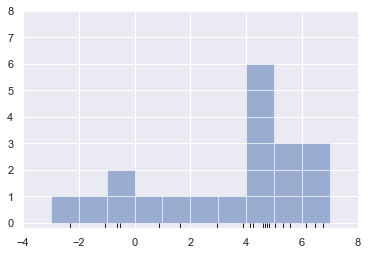

In [35]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)

ax.plot(x, np.full_like(x, -0.1),'|k',
        markeredgewidth=1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                    alpha=0.5))

ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binnings stems from the fact the height of the block stack often reflects not on the actual density of points nerby, but on coincidences of how the bings align with the dat apoints. this mis-alignment between points and their blocks is a potentia lcause of the ppor histogram results seen here. But what if, instead of stacking the blocks aligned with the *bins*, we were to stack the blocks aligned with the *points they represent*? If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result. Let's try this:

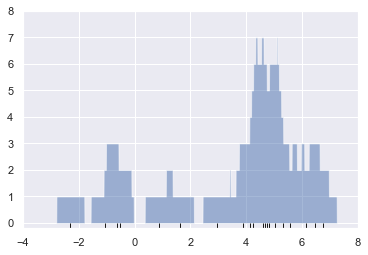

In [36]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more reboust refelction of the actual data characteristics than is the standard histogram. Still, the rough edges are not aesthetically pleasing, nor are they reflective of any true properties of the data. in order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian. Let's use a standard normal curve at each point instead of a block:

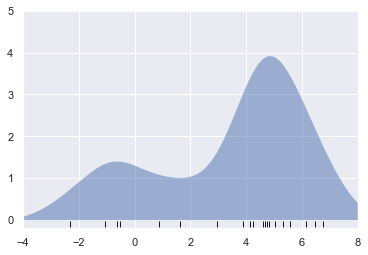

In [37]:
from scipy.stats import norm 
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contriuted at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one which as much less variance (i.e, changes much less in response to differences in sampling).

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the seocnd uses a Gaussian kernel. We'll now look at kernel density estimation in more detail.